In [ ]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [24]:

# read pickle
with open('all_financials_300.pkl', 'rb') as f:
    df = pickle.load(f)
df = df.reset_index()

df[['order_book_id','date','close']]
pivot_df = df.pivot(index='date', columns='order_book_id', values='close')
pivot_df

/var/folders/1f/5ggn6k991fv0z5vzr6xpyxx80000gn/T/ipykernel_28108/661099840.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


order_book_id,000001.XSHE,000166.XSHE,000617.XSHE,000627.XSHE,000686.XSHE,000712.XSHE,000728.XSHE,000750.XSHE,000776.XSHE,000783.XSHE,...,601878.XSHG,601881.XSHG,601901.XSHG,601916.XSHG,601939.XSHG,601988.XSHG,601990.XSHG,601995.XSHG,601997.XSHG,601998.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.6677,NaN,9.3757,3.4830,15.1487,9.9166,9.1438,0.703,3.6633,6.5980,...,NaN,NaN,NaN,NaN,2.6927,1.8294,NaN,NaN,NaN,4.1854
2010-01-05,6.5524,NaN,9.5017,3.5295,15.6647,10.2000,9.5486,0.703,3.6633,6.9615,...,NaN,NaN,NaN,NaN,2.7323,1.8507,NaN,NaN,NaN,4.2372
2010-01-06,6.4399,NaN,9.5258,3.4923,15.5075,10.0991,9.5706,0.703,3.6633,7.0174,...,NaN,NaN,NaN,NaN,2.6883,1.8294,NaN,NaN,NaN,4.1180
2010-01-07,6.3696,NaN,9.1236,3.5063,15.0842,10.0751,9.4958,0.703,3.6633,6.8916,...,NaN,NaN,NaN,NaN,2.6487,1.7953,NaN,NaN,NaN,3.9779
2010-01-08,6.3555,NaN,9.1296,3.4923,15.1890,10.3969,9.6278,0.703,3.6633,7.1397,...,NaN,NaN,NaN,NaN,2.6575,1.8038,NaN,NaN,NaN,4.0142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,11.3800,5.01,6.4300,3.9400,7.9900,12.7100,7.9400,4.070,15.7300,6.4800,...,11.65,17.35,7.95,2.95,8.5800,5.4000,8.39,35.01,5.92,7.3400
2025-03-25,11.4300,5.01,6.4400,3.8700,8.0000,12.5800,7.9600,4.080,15.8100,6.4900,...,11.81,16.77,7.91,2.96,8.6500,5.4800,8.39,34.49,5.93,7.2800
2025-03-26,11.3800,5.05,6.4400,3.8700,8.0000,12.6300,7.9400,4.100,15.7900,6.4900,...,11.71,16.86,7.92,2.95,8.5900,5.4800,8.39,34.54,5.91,7.2500


In [ ]:
from joblib import Parallel, delayed

def test_pair(data, i, j, significance=0.0001):
    tmp = data.iloc[:, [i, j]].dropna()
    stock1 = tmp.iloc[:, 0]
    stock2 = tmp.iloc[:, 1]
    print(f"Testing {data.columns[i]} and {data.columns[j]}")
    try:
        _, pvalue, _ = coint(stock1, stock2)
        if pvalue < significance:
            return (data.columns[i], data.columns[j], pvalue)
    except Exception as e:
        print(f"Error testing {data.columns[i]} and {data.columns[j]}: {e}")
    return None

def find_cointegrated_pairs_parallel(data, significance=0.000001, n_jobs=-1):
    n = data.shape[1]
    results = Parallel(n_jobs=n_jobs)(
        delayed(test_pair)(data, i, j, significance) for i in range(n) for j in range(i + 1, n)
    )
    pairs = [(res[0], res[1]) for res in results if res is not None]
    pvalues = [res[2] for res in results if res is not None]
    return pd.DataFrame({'Pair': pairs, 'P-value': pvalues}).sort_values('P-value')

# Find cointegrated pairs in the training period
cointegrated_pairs = find_cointegrated_pairs_parallel(pivot_df)
print("Cointegrated Pairs:\n", cointegrated_pairs)

In [ ]:
cointegrated_pairs

,Pair,P-value
6,"(600928.XSHG, 601696.XSHG)",7.277784e-10
11,"(601818.XSHG, 601825.XSHG)",1.823000e-09
10,"(601696.XSHG, 601990.XSHG)",2.124721e-09
9,"(601236.XSHG, 601995.XSHG)",3.326611e-09
2,"(000776.XSHE, 601788.XSHG)",4.031279e-09
1,"(000776.XSHE, 600999.XSHG)",3.049899e-08
7,"(600928.XSHG, 601997.XSHG)",5.613703e-08
5,"(600918.XSHG, 600928.XSHG)",8.241924e-08
4,"(600643.XSHG, 601236.XSHG)",1.163991e-07
0,"(000712.XSHE, 600958.XSHG)",2.767703e-07


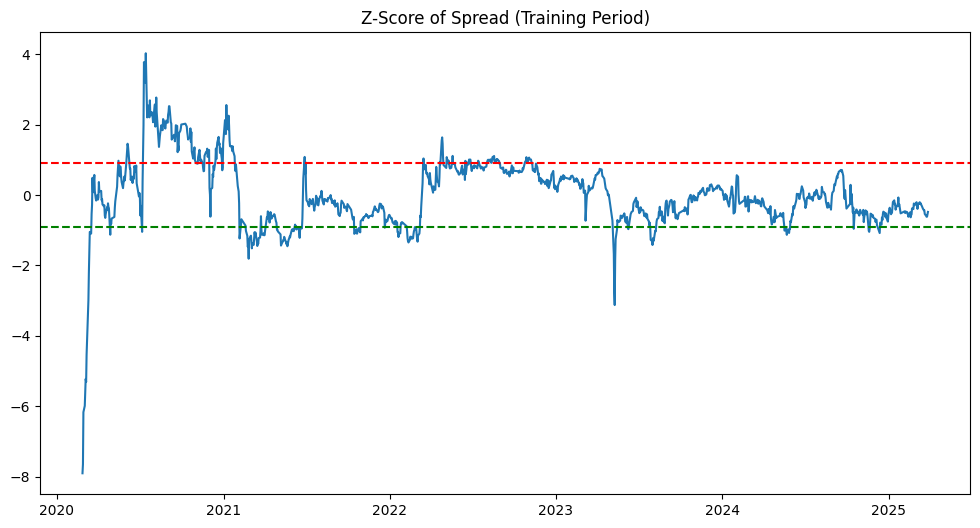

Total Return: 56.92
Sharpe Ratio: 1.67


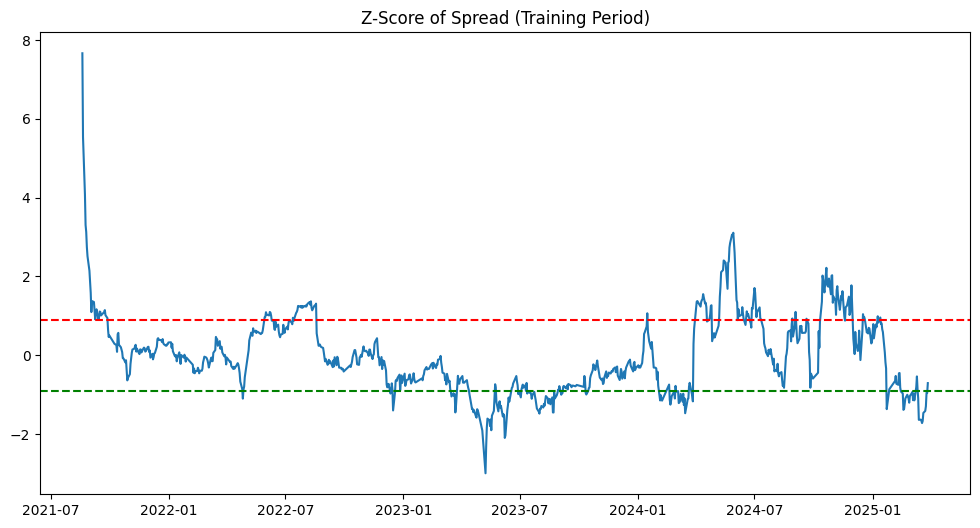

Total Return: 7.02
Sharpe Ratio: 1.83


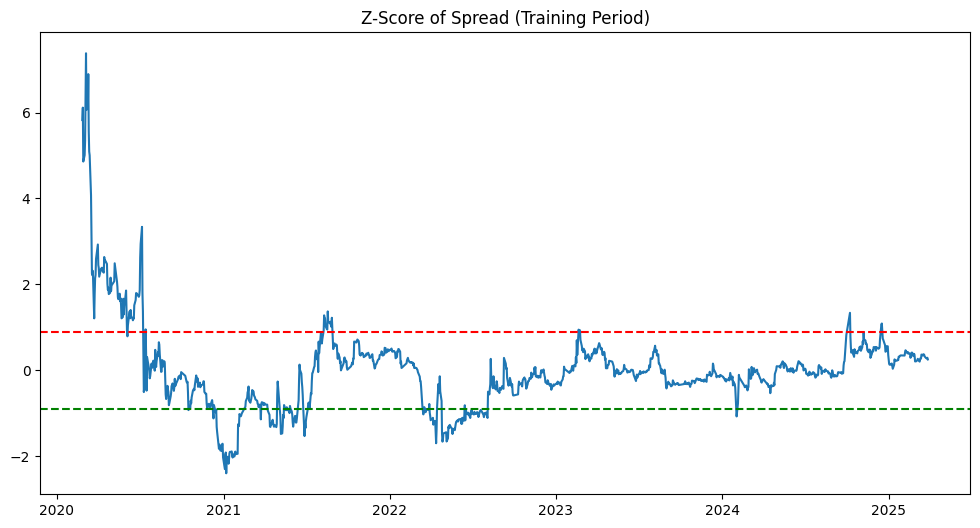

Total Return: 13.09
Sharpe Ratio: 1.10


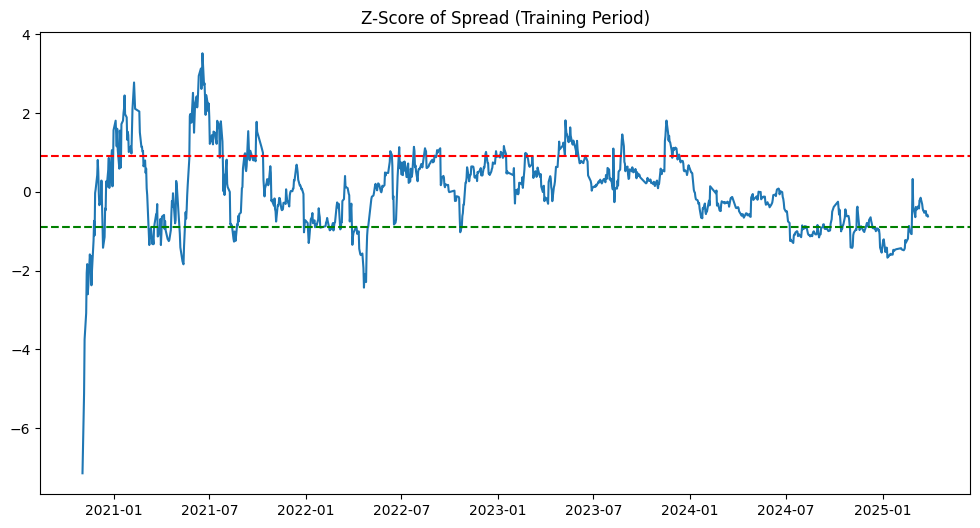

Total Return: 113.41
Sharpe Ratio: 2.57


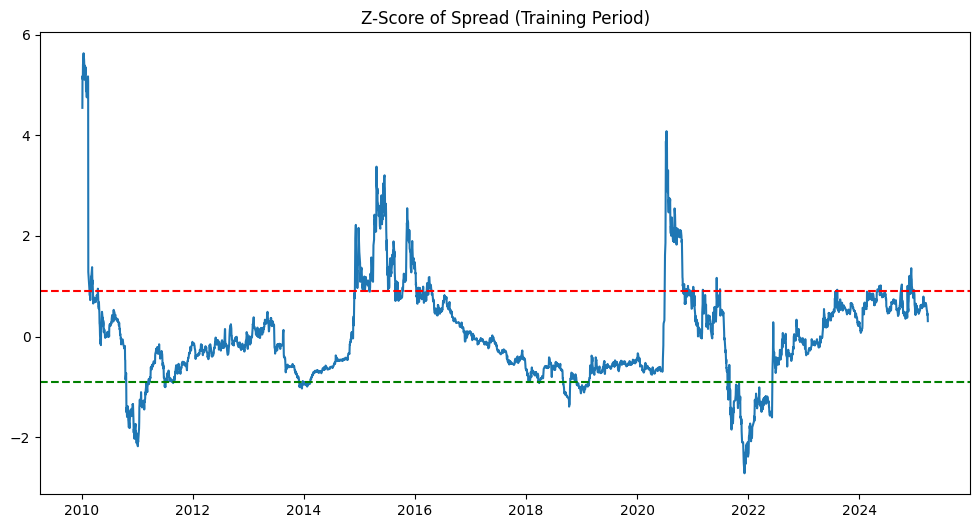

Total Return: 35.18
Sharpe Ratio: 0.50


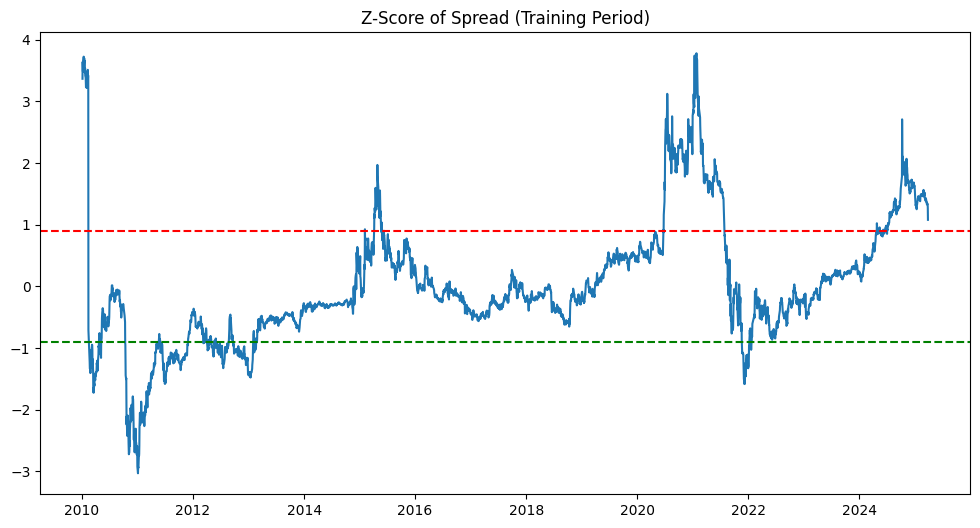

Total Return: 19.81
Sharpe Ratio: 0.34


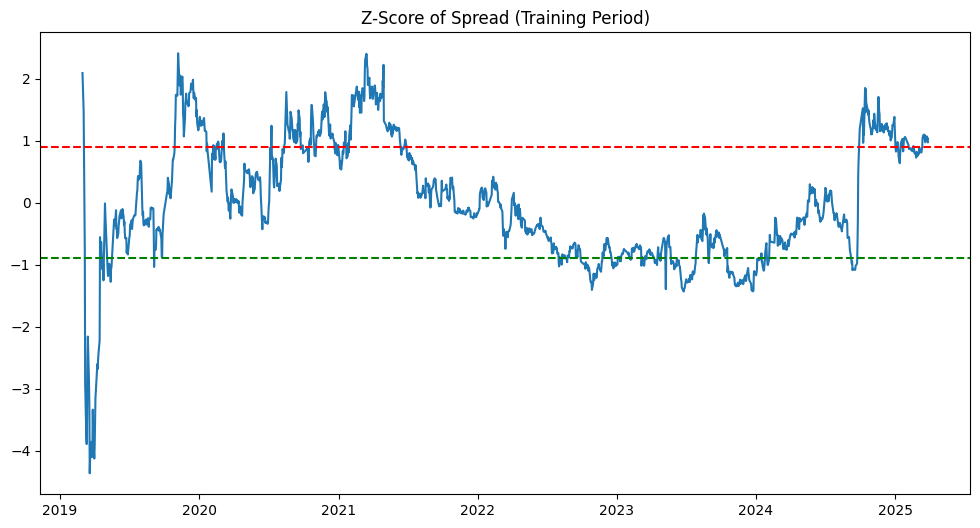

Total Return: 4.93
Sharpe Ratio: 1.07


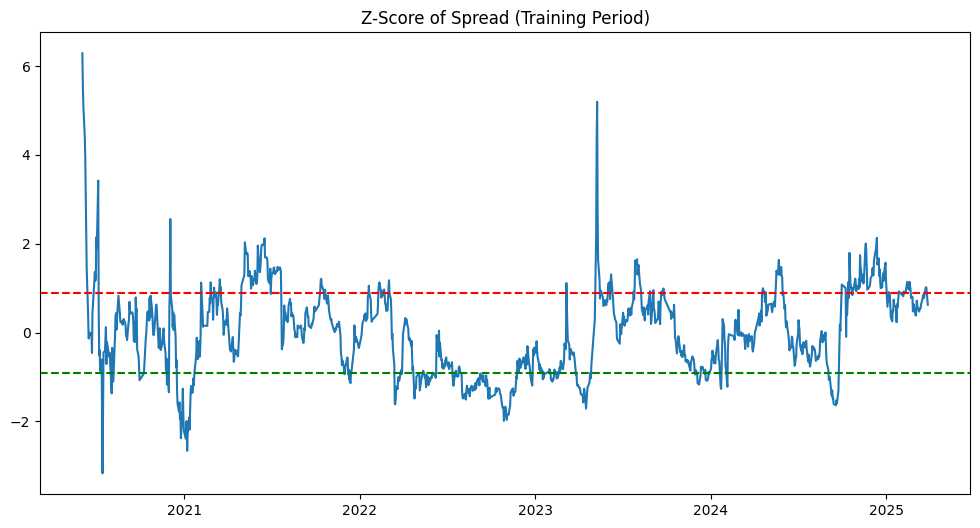

Total Return: 5.84
Sharpe Ratio: 1.86


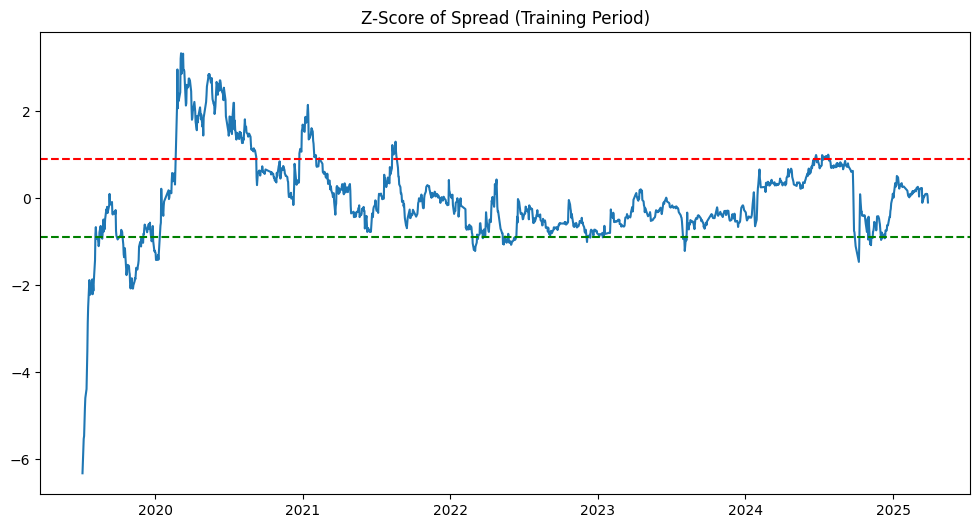

Total Return: 23.59
Sharpe Ratio: 1.26


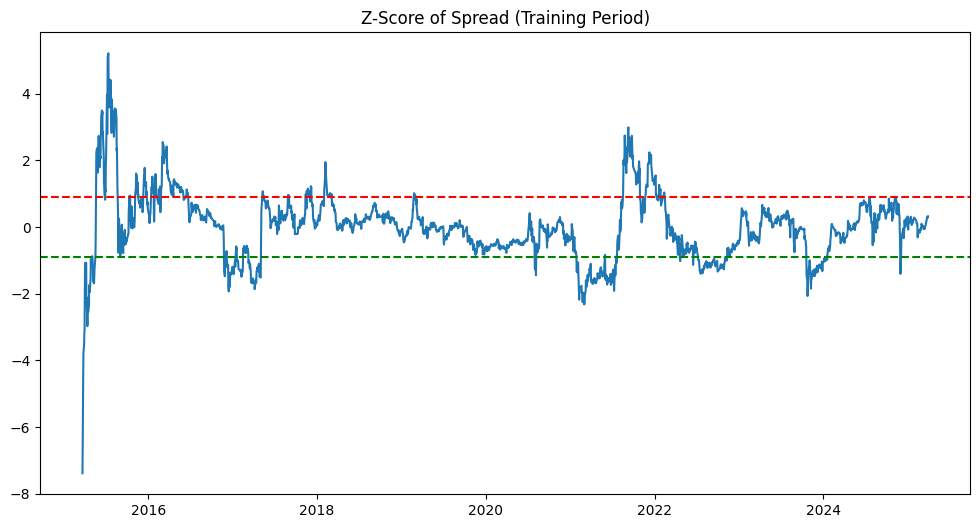

Total Return: 33.18
Sharpe Ratio: 0.83


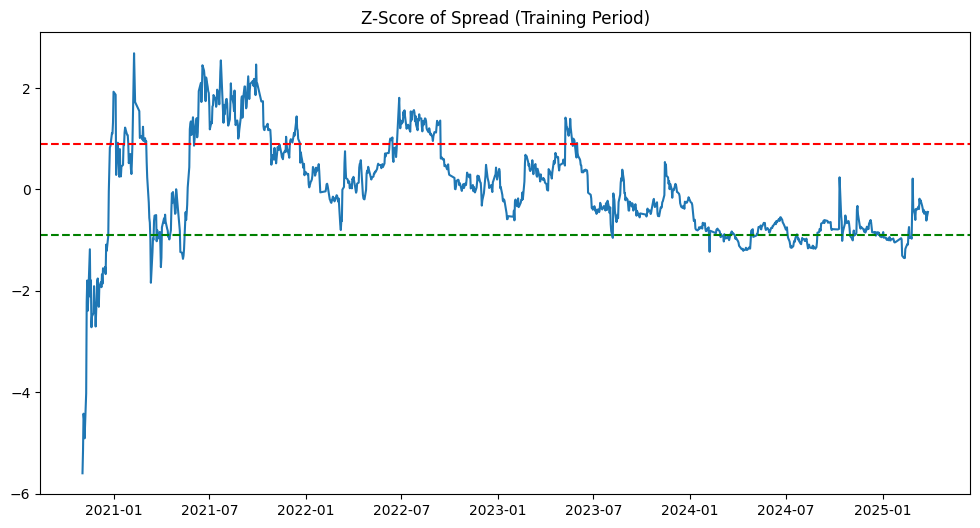

Total Return: 69.02
Sharpe Ratio: 1.31


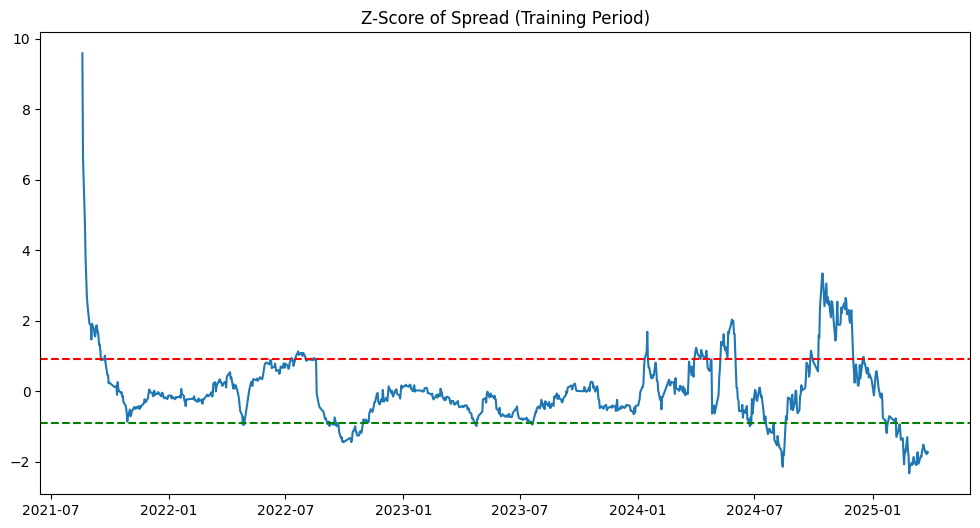

Total Return: 4.42
Sharpe Ratio: 1.42


In [23]:
# Example: Take the first cointegrated pai
data_dict = {}
for i in range(len(cointegrated_pairs)):

    stock_a, stock_b = cointegrated_pairs.iloc[i]['Pair']

    # Calculate spread (hedge ratio via linear regression)
    from sklearn.linear_model import LinearRegression
    tmp = pivot_df[[stock_a, stock_b]].dropna()
    X = tmp[stock_a].values.reshape(-1, 1)
    y = tmp[stock_b].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    hedge_ratio = model.coef_[0][0]
    spread = tmp[stock_b] - hedge_ratio * tmp[stock_a]

    # Z-score normalization
    mean = spread.mean()
    std = spread.std()
    z_score = (spread - mean) / std

    # Plot training spread
    plt.figure(figsize=(12, 6))
    plt.plot(z_score)
    plt.axhline(0.9, color='red', linestyle='--')
    plt.axhline(-0.9, color='green', linestyle='--')
    plt.title('Z-Score of Spread (Training Period)')
    plt.show()

    # Apply to test data
    test = tmp
    test_spread = test[stock_b] - hedge_ratio * test[stock_a]
    test_z = (test_spread - mean) / std

    # Signals: Long when Z < -2, Short when Z > 2
    test_signals = pd.DataFrame(index=test.index)
    test_signals['z'] = test_z
    test_signals['position'] = 0
    test_signals.loc[test_signals['z'] > 0.9, 'position'] = -1  # Short spread
    test_signals.loc[test_signals['z'] < -0.9, 'position'] = 1   # Long spread
    test_signals.loc[(test_signals['z'] < 0.1) & (test_signals['z'] > -0.1), 'position'] = 0  # Exit

    # Compute returns
    test_returns = test_signals['position'].shift(1) * (test_spread.diff())
    cumulative_returns = test_returns.cumsum()

    # Plot results
    plt.figure(figsize=(12, 6))
    cumulative_returns.plot()
    plt.title('Cumulative Returns (Test Period)')
    plt.ylabel('Returns')
    # avoid show the plot 
    plt.close()

    # Performance metrics
    total_return = cumulative_returns.iloc[-1]
    sharpe_ratio = test_returns.mean() / test_returns.std() * np.sqrt(252)
    print(f"Total Return: {total_return:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    data_dict[i] = {
        'stock_a': stock_a,
        'stock_b': stock_b,
        'hedge_ratio': hedge_ratio,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
    }


In [ ]:
def johansen_cointegration(data, det_order=0, k_ar_diff=1, significance_level=0.05):
    """Perform Johansen’s cointegration test."""

    result = coint_johansen(data, det_order, k_ar_diff)
    
    # Critical values at 95%
    critical_values = result.cvt[:, 1]  # 95% confidence column
    
    # Check if eigenvalues > critical values
    cointegrated = result.eig > critical_values
    num_cointegrated = sum(cointegrated)
    
    # Extract eigenvectors (cointegrating vectors)
    eigenvectors = result.evec[:, :num_cointegrated]
    
    return num_cointegrated, eigenvectors

# Run Johansen’s test on training data
num_coint, eigenvectors = johansen_cointegration(pivot_df)
print(f"Number of cointegrated relationships: {num_coint}")

# Use the first cointegrating vector (most significant)
coint_vector = eigenvectors[:, 0]

In [15]:
pivot_df

order_book_id,000001.XSHE,000166.XSHE,000617.XSHE,000627.XSHE,000686.XSHE,000712.XSHE,000728.XSHE,000750.XSHE,000776.XSHE,000783.XSHE,...,601878.XSHG,601881.XSHG,601901.XSHG,601916.XSHG,601939.XSHG,601988.XSHG,601990.XSHG,601995.XSHG,601997.XSHG,601998.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.6677,NaN,9.3757,3.4830,15.1487,9.9166,9.1438,0.703,3.6633,6.5980,...,NaN,NaN,NaN,NaN,2.6927,1.8294,NaN,NaN,NaN,4.1854
2010-01-05,6.5524,NaN,9.5017,3.5295,15.6647,10.2000,9.5486,0.703,3.6633,6.9615,...,NaN,NaN,NaN,NaN,2.7323,1.8507,NaN,NaN,NaN,4.2372
2010-01-06,6.4399,NaN,9.5258,3.4923,15.5075,10.0991,9.5706,0.703,3.6633,7.0174,...,NaN,NaN,NaN,NaN,2.6883,1.8294,NaN,NaN,NaN,4.1180
2010-01-07,6.3696,NaN,9.1236,3.5063,15.0842,10.0751,9.4958,0.703,3.6633,6.8916,...,NaN,NaN,NaN,NaN,2.6487,1.7953,NaN,NaN,NaN,3.9779
2010-01-08,6.3555,NaN,9.1296,3.4923,15.1890,10.3969,9.6278,0.703,3.6633,7.1397,...,NaN,NaN,NaN,NaN,2.6575,1.8038,NaN,NaN,NaN,4.0142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,11.3800,5.01,6.4300,3.9400,7.9900,12.7100,7.9400,4.070,15.7300,6.4800,...,11.65,17.35,7.95,2.95,8.5800,5.4000,8.39,35.01,5.92,7.3400
2025-03-25,11.4300,5.01,6.4400,3.8700,8.0000,12.5800,7.9600,4.080,15.8100,6.4900,...,11.81,16.77,7.91,2.96,8.6500,5.4800,8.39,34.49,5.93,7.2800
2025-03-26,11.3800,5.05,6.4400,3.8700,8.0000,12.6300,7.9400,4.100,15.7900,6.4900,...,11.71,16.86,7.92,2.95,8.5900,5.4800,8.39,34.54,5.91,7.2500


In [22]:
det_order = 0
k_ar_diff = 1
data = pivot_df[['000001.XSHE','000166.XSHE','000617.XSHE']].dropna()

result = coint_johansen(data, det_order, k_ar_diff)

# Critical values at 95%
critical_values = result.cvt[:, 1]  # 95% confidence column

# Check if eigenvalues > critical values
cointegrated = result.eig > critical_values
num_cointegrated = sum(cointegrated)

# Extract eigenvectors (cointegrating vectors)
eigenvectors = result.evec[:, :num_cointegrated]
result.eig


array([0.00943778, 0.00736454, 0.00138174])

In [ ]:
Regression, PCA: o

order_book_id,000001.XSHE,000166.XSHE,000617.XSHE,000627.XSHE,000686.XSHE,000712.XSHE,000728.XSHE,000750.XSHE,000776.XSHE,000783.XSHE,...,601878.XSHG,601881.XSHG,601901.XSHG,601916.XSHG,601939.XSHG,601988.XSHG,601990.XSHG,601995.XSHG,601997.XSHG,601998.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2023-02-01,13.1072,4.1413,5.9978,3.2480,6.8639,13.90,6.9235,3.5210,16.9750,5.6124,...,10.5988,9.5652,7.0183,2.4702,4.8903,2.8202,8.3822,40.4368,5.0300,4.4227
2023-02-02,13.0180,4.1510,5.8739,3.2287,6.7866,13.73,6.7338,3.4820,16.4433,5.5741,...,10.4434,9.4029,6.9292,2.4619,4.8816,2.8115,8.3141,40.4467,5.0031,4.4052
2023-02-03,12.7683,4.1119,5.9215,3.1900,6.7480,13.73,6.7149,3.4527,16.2629,5.5550,...,10.3754,9.3265,6.8995,2.4453,4.8729,2.8115,8.2849,40.3480,4.9761,4.3613
2023-02-06,12.4830,4.0923,5.8071,3.1610,6.7094,13.55,6.6580,3.4234,15.8262,5.5072,...,10.2394,9.2502,6.7906,2.4287,4.8642,2.8027,8.3822,39.2333,4.9492,4.3350
2023-02-07,12.6703,4.0923,5.8262,3.1707,6.5839,13.53,6.6580,3.4332,15.8547,5.4498,...,10.2491,9.2311,6.8104,2.4370,4.8642,2.7939,8.3238,39.6969,4.9671,4.3437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,11.3800,5.0100,6.4300,3.9400,7.9900,12.71,7.9400,4.0700,15.7300,6.4800,...,11.6500,17.3500,7.9500,2.9500,8.5800,5.4000,8.3900,35.0100,5.9200,7.3400
2025-03-25,11.4300,5.0100,6.4400,3.8700,8.0000,12.58,7.9600,4.0800,15.8100,6.4900,...,11.8100,16.7700,7.9100,2.9600,8.6500,5.4800,8.3900,34.4900,5.9300,7.2800
2025-03-26,11.3800,5.0500,6.4400,3.8700,8.0000,12.63,7.9400,4.1000,15.7900,6.4900,...,11.7100,16.8600,7.9200,2.9500,8.5900,5.4800,8.3900,34.5400,5.9100,7.2500
